''' -- coding:utf-8 -- @author: Huaiyu Dong ＆ Yixing Huang @Time: 2023-10-23 @Explanition: This code aims to predict the EAB of microwave absorber structure using the DNN neural network architecture. '''

# 数据可视化

In [5]:
import pandas as pd
# 用pandas加载CSV文件
data = pd.read_csv(r'D:\1PhD study\DNN reproduction\PETALS PAPER\mydata_petals.csv')
# 显示数据的前几行以查看数据的结构
print(data.head())

      tr1     br1     d1     t2     xr1    yr1     xr2    yr2     xr3    yr3  \
0   5.724  15.934  1.240  9.735  13.433  1.936  12.729  5.877  11.823  3.646   
1   5.561  13.123  3.206  9.805  13.110  3.885  15.206  5.681  15.074  6.299   
2  10.193  13.614  2.108  8.664  14.901  5.620  13.897  4.730  12.113  5.970   
3   8.411  17.177  3.306  9.739  10.550  3.867  12.373  1.797  11.508  5.257   
4   5.144  14.504  1.068  9.100  10.933  4.832  13.322  6.349  12.346  3.148   

   EAB  
0   78  
1   33  
2   79  
3   54  
4   68  


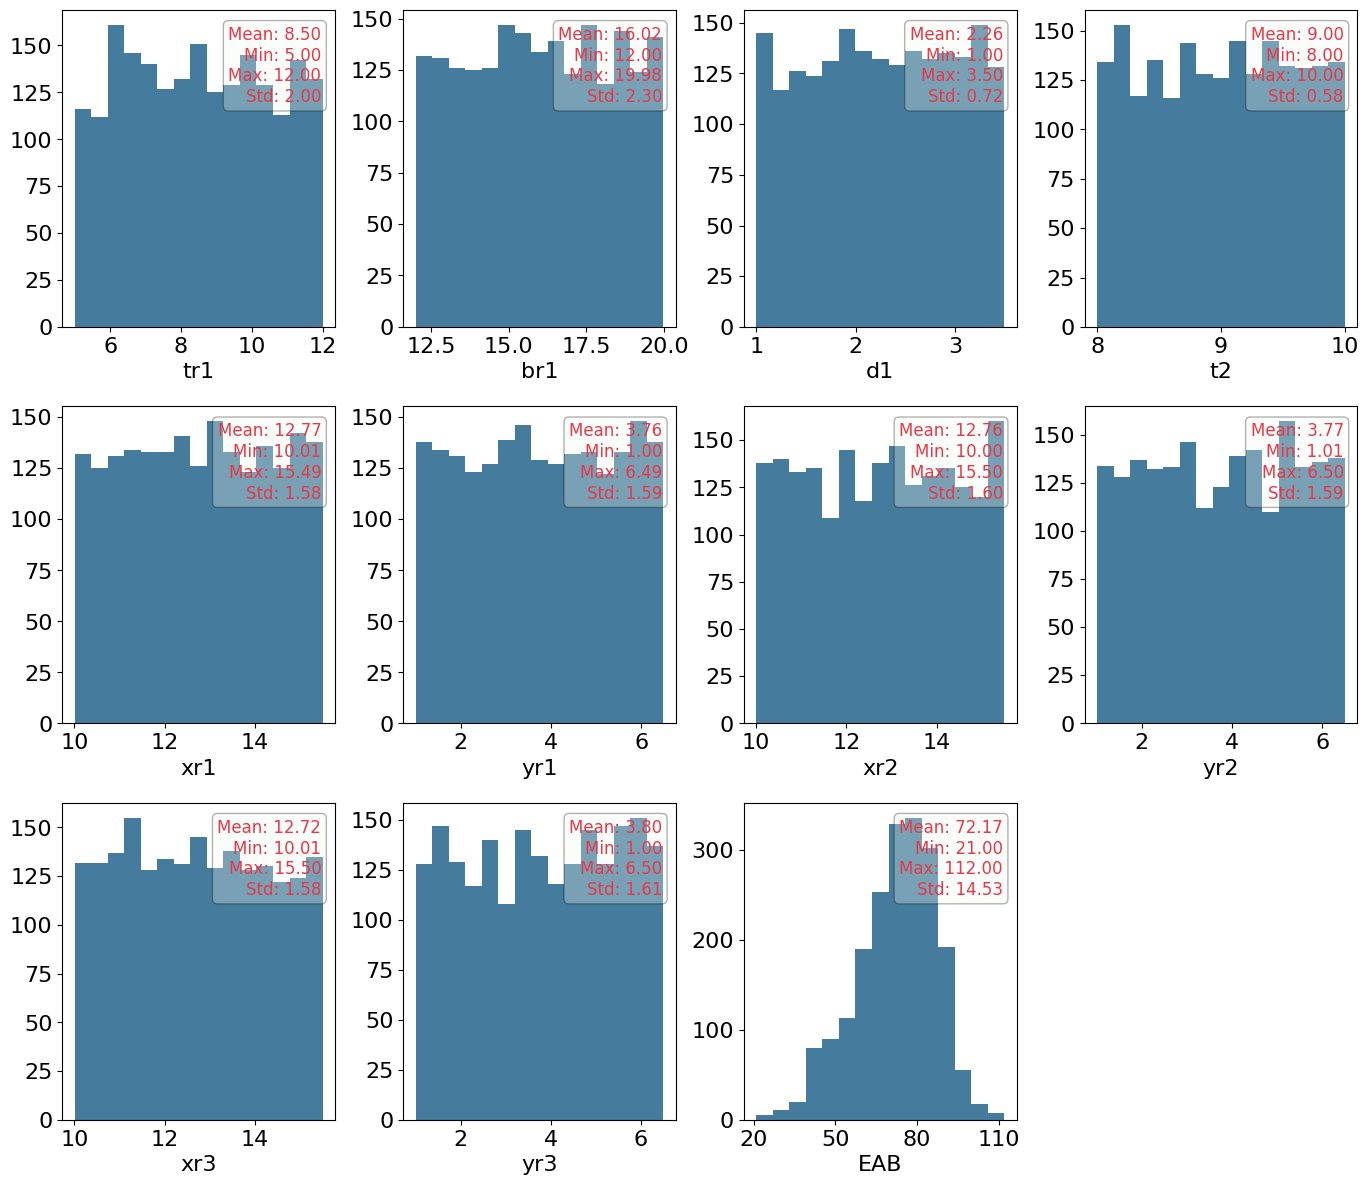

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 数据集的列名
column_names = data.columns

# 设置子图的布局
fig, axes = plt.subplots(3, 4, figsize=(14, 12))
fig.subplots_adjust(hspace=0.25, wspace=0.25, left=0.05, right=0.975, top=0.975, bottom=0.05)

# 绘制直方图和添加图例
for i in range(3):
    for j in range(4):
        ax = axes[i, j]
        index = i * 4 + j
        if index < len(column_names):
            feature_name = column_names[index]
            feature_data = data[feature_name]
            
            # 绘制直方图
            _, bins, _ = ax.hist(feature_data, bins=15, color=(69/255, 123/255, 157/255,1))
            
            # 计算统计信息
            mean_value = np.mean(feature_data)
            min_value = np.min(feature_data)
            max_value = np.max(feature_data)
            std_value = np.std(feature_data)
            
            legend_text = f'Mean: {mean_value:.2f}\nMin: {min_value:.2f}\nMax: {max_value:.2f}\nStd: {std_value:.2f}'
            ax.text(0.95, 0.95, legend_text,  color=(231/255, 56/255, 71/255,1), verticalalignment='top', horizontalalignment='right', transform=ax.transAxes, fontsize=12, bbox=dict(boxstyle='round', facecolor=(240/255, 250/255, 239/255, 0.3), alpha=0.3))
        
            # 设置 x 轴刻度为四个点，取整数值
            ax.set_xlabel(feature_name, fontsize=16)
            
            # 设置 x 轴刻度
            if i == 2 and j == 2:
                # Assuming you want ticks at specific positions, adjust the list accordingly
                tick_positions = [20, 50, 80, 110]  # Adjust these values based on your data
                ax.set_xticks(tick_positions)
            
            # 调整 x 轴和 y 轴刻度标签的字体大小
            ax.tick_params(axis='x', labelsize=16)
            ax.tick_params(axis='y', labelsize=16)
            
            # 仅在第一列的子图上添加 ylabel
            #if j == 0:
                #ax.set_ylabel('Frequency', fontsize=14)
        else:
            # 删除多余的子图
            fig.delaxes(ax)

# 提高图的分辨率并保存为TIFF文件
#plt.savefig('output_figure1.tiff', dpi=300, format='tiff')
# 显示图形
plt.show()

###归一化+有数据增强功能###
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Set random seed for PyTorch and NumPy
seed = 14618
torch.manual_seed(seed)
np.random.seed(seed)

# Load your data from mydata_petals.csv
data = pd.read_csv('mydata_petals.csv')

# Extract the last column (EAB) as the target variable
EAB = data.iloc[:, -1].values

# Extract the first 10 columns as input features
input = data.iloc[:, :-1].values

# Data Augmentation: Create additional samples through bootstrapping
n_samples = len(EAB)
n_additional_samples = 2000 # Number of additional samples to create (adjust as needed)
additional_samples_indices = np.random.choice(n_samples, n_additional_samples, replace=True)

additional_input = input[additional_samples_indices]
additional_EAB = EAB[additional_samples_indices]

# Concatenate the additional data with the original data
input = np.vstack((input, additional_input))
EAB = np.hstack((EAB, additional_EAB))

# Create MinMaxScaler objects for input and EAB
scaler_in = MinMaxScaler(feature_range=(-0.5, 0.5))
scaler_out = MinMaxScaler(feature_range=(-0.99, 0.99))

# Fit and transform input data, and store the transformation matrix ps_in
p_scaled = scaler_in.fit_transform(input)
p = torch.FloatTensor(p_scaled.T)
ps_in = scaler_in.scale_

# Fit and transform EAB data, and store the transformation matrix ts_out
t_scaled = scaler_out.fit_transform(EAB.reshape(-1, 1))
t = torch.FloatTensor(t_scaled)
ts_out = scaler_out.scale_

print("Scaled Data Shapes:")
print(p_scaled.shape)
print(t_scaled.shape)

# Define the ratio for training and testing data
train_ratio = 0.8  # 80% training data, 20% testing data
test_ratio = 0.2

# Number of samples
n_samples = len(EAB)

# Create a random permutation of indices for shuffling
indices = np.random.permutation(n_samples)

# Calculate the sizes of the training and test sets
n_train = int(train_ratio * n_samples)
n_test = n_samples - n_train

# Use the shuffled indices to split the data into training and test sets
train_indices = indices[:n_train]
test_indices = indices[n_train:]

# Split the data into training and test sets based on the shuffled indices
X_train, y_train = p_scaled[train_indices], t_scaled[train_indices]
X_test, y_test = p_scaled[test_indices], t_scaled[test_indices]

print("Training Data Shapes:")
print(X_train.shape, y_train.shape)
print("Test Data Shapes:")
print(X_test.shape, y_test.shape)

# Print the first 5 rows of training and test data
print("First 5 rows of Training Data:")
print(X_train[:5])
print("First 5 rows of Training Target (y_train):")
print(y_train[:5])

print("First 5 rows of Test Data:")
print(X_test[:5])
print("First 5 rows of Test Target (y_test):")
print(y_test[:5])

In [ ]:
###归一化、无数据增强功能###
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# Set random seed for PyTorch and NumPy
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Load your data from mydata_petals.csv
data = pd.read_csv('mydata_petals.csv')

# Extract the last column (EAB) as the target variable
EAB = data.iloc[:, -1].values

# Extract the first 10 columns as input features
input = data.iloc[:, :-1].values

# Create MinMaxScaler objects for input and EAB
scaler_in = MinMaxScaler(feature_range=(-0.5, 0.5))
scaler_out = MinMaxScaler(feature_range=(-0.99, 0.99))

# Fit and transform input data, and store the transformation matrix ps_in
p_scaled = scaler_in.fit_transform(input)
p = torch.FloatTensor(p_scaled.T)
ps_in = scaler_in.scale_

# Fit and transform EAB data, and store the transformation matrix ts_out
t_scaled = scaler_out.fit_transform(EAB.reshape(-1, 1))
t = torch.FloatTensor(t_scaled)
ts_out = scaler_out.scale_

print("Scaled Data Shapes:")
print(p_scaled.shape)
print(t_scaled.shape)

# Define the ratio for training and testing data
train_ratio = 0.80  # 80% training data, 
test_ratio = 0.20   # 20% testing data

# Number of samples
n_samples = len(EAB)

# Create a random permutation of indices for shuffling
indices = np.random.permutation(n_samples)

# Calculate the sizes of the training and test sets
n_train = int(train_ratio * n_samples)
n_test = n_samples - n_train

# Use the shuffled indices to split the data into training and test sets
train_indices = indices[:n_train]
test_indices = indices[n_train:]

# Split the data into training and test sets based on the shuffled indices
X_train, y_train = p_scaled[train_indices], t_scaled[train_indices]
X_test, y_test = p_scaled[test_indices], t_scaled[test_indices]

print("Training Data Shapes:")
print(X_train.shape, y_train.shape)
print("Test Data Shapes:")
print(X_test.shape, y_test.shape)

# 打印训练数据前五行
print("First 5 rows of Training Data:")
print(X_train[:5])
print("First 5 rows of Training Target (y_train):")
print(y_train[:5])

print("Test Data Shapes:")
print(X_test.shape, y_test.shape)

# 打印测试数据前五行
print("First 5 rows of Test Data:")
print(X_test[:5])
print("First 5 rows of Test Target (y_test):")
print(y_test[:5])

In [ ]:
####无网格搜索功能、无Dropout技术####
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import time

# Define the architecture of the DNN with hidden layers
class DNN(nn.Module):      #无初始化功能
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            self.layers.append(nn.Linear(dims[i - 1], dims[i]))
            if i < len(dims) - 1:
                self.layers.append(nn.Tanh())  #双曲正切
                #self.layers.append(nn.ReLU())   #ReLU
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

kk1 = 20   # Neuron number in 1st hidden layer 14
kk2 = 10  # Neuron nu#mber in 2nd hidden layer12
kk3 = 8  # Neuron number in 3rd hidden layer8
kk4 = 3  # Neuron number in 4th hidden layer  3
#kk5 = 4  # Neuron number in 4th hidden layer 
# Hyperparameters
input_dim = 10  # Input dimension (adjust as needed)
output_dim = 1  # Output dimension
hidden_dims = [kk1, kk2, kk3, kk4]  # , kk4, kk5 Hidden layer dimensions (adjust as needed)
learning_rate = 0.02  # Learning rate
max_epochs = 300  # Maximum epochs (adjust as needed)

# Initialize the DNN
dnn = DNN(input_dim, output_dim, hidden_dims)

# Define the optimizer and loss function
optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Convert data to PyTorch tensors
inputs = torch.FloatTensor(X_train)
targets = torch.FloatTensor(y_train)

# Record the start time
start_time = time.time()

losses = []
# Train the DNN
for epoch in range(max_epochs):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = dnn(inputs)
    
    # Calculate the loss
    loss = criterion(outputs, targets)
    losses.append(loss.item())
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Print loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/{max_epochs}], Loss: {loss.item():.4f}")
        
# Record the end time
end_time = time.time()
# Calculate and print the training duration
training_duration = end_time - start_time
print(f"Training duration: {training_duration:.2f} seconds")

# 绘制损失曲线
plt.figure()
plt.plot(range(1, max_epochs + 1), losses, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()  

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
with torch.no_grad():
    predicted_train = dnn(torch.FloatTensor(X_train))
    train_true_values = y_train
    r_train = r2_score(train_true_values, predicted_train)
    mae_train = mean_absolute_error(train_true_values, predicted_train)   # MAE training set
    mse_train = mean_squared_error(train_true_values, predicted_train)    # MSE training set
    rmse_train = math.sqrt(mse_train)                               # RMSE training set

print(f"R-squared (r_train) on training set: {r_train:.3f}")
print(f"Mean Absolute Error (MAE) on training set: {mae_train:.3f}")
print(f"Mean Squared Error (MSE) on training set: {mse_train:.3f}")
print(f"Root Mean Squared Error (RMSE) on training set: {rmse_train:.3f}")

with torch.no_grad():              # Perform regression analysis on the test set (X_test, y_test)
    predicted_test = dnn(torch.FloatTensor(X_test))
    test_true_values = y_test
    r_test = r2_score(test_true_values, predicted_test)
    mae_test = mean_absolute_error(test_true_values, predicted_test)   #MAE test set
    mse_test = mean_squared_error(test_true_values, predicted_test)    # MSE test set
    rmse_test = math.sqrt(mse_test)                               #RMSE test set
    predicted_train = dnn(torch.FloatTensor(X_train))

print(f"R-squared (r_test) on test set: {r_test:.3f}")
print(f"Mean Absolute Error (MAE) on test set: {mae_test:.3f}")
print(f"Mean Squared Error (MSE) on test set: {mse_test:.3f}")
print(f"Root Mean Squared Error (RMSE) on test set: {rmse_test:.3f}")
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

actual_train = y_train
actual_test = y_test  

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot of actual values and regression line for training set
axes[0].scatter(actual_train, actual_train, color='blue', label='Actual', marker='o', s=10)
axes[0].scatter(actual_train, predicted_train, color='red', label='Predicted', marker='x', s=10)
axes[0].set_xlim(-1.2, 1.2)
axes[0].set_ylim(-1.2, 1.2)
correlation_train = np.corrcoef(actual_train, predicted_train, rowvar=False)[0, 1]
print(f"correlation_train: {correlation_train:.3f}")

axes[0].set_title(f'Training Set\nCorrelation: {correlation_train:.3f}')
regression_train = LinearRegression()
regression_train.fit(actual_train.reshape(-1, 1), predicted_train)
regression_line_train = regression_train.predict(actual_train.reshape(-1, 1))
axes[0].plot(actual_train, regression_line_train, color='green', linestyle='--', label='Regression Line')
axes[0].legend()

# Scatter plot of actual values and regression line for test set
axes[1].scatter(actual_test, actual_test, color='blue', label='Actual', marker='o', s=10)
axes[1].scatter(actual_test, predicted_test, color='red', label='Predicted', marker='x', s=10)
axes[1].set_xlim(-1.2, 1.2)
axes[1].set_ylim(-1.2, 1.2)
correlation_test = np.corrcoef(actual_test, predicted_test, rowvar=False)[0, 1]
print(f"correlation_test: {correlation_test:.3f}")
axes[1].set_title(f'Test Set\nCorrelation: {correlation_test:.3f}')
regression_test = LinearRegression()
regression_test.fit(actual_test.reshape(-1, 1), predicted_test)
regression_line_test = regression_test.predict(actual_test.reshape(-1, 1))
axes[1].plot(actual_test, regression_line_test, color='green', linestyle='--', label='Regression Line')
axes[1].legend()
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np
num_samples_to_plot = 150  # Set the number of samples you want to plot

# Plotting the actual and predicted values for the first 'num_samples_to_plot' samples
plt.plot(actual_test[:num_samples_to_plot], label='Actual', marker='o')
plt.plot(predicted_test[:num_samples_to_plot], label='Predicted', marker='x')

plt.title(f'Comparison of Actual and Predicted Values in Test Set (First {num_samples_to_plot} Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Plotting the actual and predicted values for the first 'num_samples_to_plot' samples in the training set
plt.plot(actual_train[:num_samples_to_plot], label='Actual (Training)', marker='o')
plt.plot(predicted_train[:num_samples_to_plot], label='Predicted (Training)', marker='x')

plt.title(f'Comparison of Actual and Predicted Values in Training Set (First {num_samples_to_plot} Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

## 遗传算法搜索最优DNN架构

import numpy as np
from deap import base, creator, tools, algorithms
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Define the architecture of the DNN with variable hidden layers
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            self.layers.append(nn.Linear(dims[i - 1], dims[i]))
            if i < len(dims) - 1:
                self.layers.append(nn.Tanh())  # You can adjust the activation function here

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Define the evaluation function for a set of hyperparameters
def evaluate(individual):
    # Extract hyperparameters
    learning_rate = np.clip(individual[0], 0.001, 0.1)  # Clip learning rate to [0.001, 0.1]
    hidden_dims = [int(np.clip(x, 3, 20)) for x in individual[1:5]]  # Clip hidden dims to [3, 20]
    max_epochs = int(np.clip(individual[5], 100, 300))  # Clip max_epochs to [100, 300]

    # Initialize the DNN
    dnn = DNN(input_dim, output_dim, hidden_dims)

    # Define the optimizer and loss function
    optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Train the DNN
    for epoch in range(max_epochs):
        optimizer.zero_grad()
        outputs = dnn(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Evaluate the DNN on the test set
    with torch.no_grad():
        predicted_test = dnn(torch.FloatTensor(X_test))
        test_true_values = y_test
        mse_test = mean_squared_error(test_true_values, predicted_test)

    return mse_test,

# Define the genetic algorithm parameters
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("learning_rate", np.random.uniform, 0.001, 0.1)
print("Learning Rate:", toolbox.learning_rate())
toolbox.register("hidden_dims", np.random.randint, 3, 21)
toolbox.register("max_epochs", np.random.randint, 100, 300)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.learning_rate, toolbox.hidden_dims, toolbox.max_epochs), n=6)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Create the initial population
population_size = 60
population = toolbox.population(n=population_size)

# Run the genetic algorithm
generations = 20
population, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=generations,
                                          stats=None, halloffame=None, verbose=True)

# Extract the best individual (best hyperparameters)
best_individual = tools.selBest(population, k=1)[0]
best_learning_rate = np.clip(best_individual[0], 0.001, 0.1)
best_hidden_dims = [int(np.clip(x, 3, 20)) for x in best_individual[1:5]]
best_max_epochs = int(np.clip(best_individual[5], 100, 300))

# Train the final DNN with the best hyperparameters
final_dnn = DNN(input_dim, output_dim, best_hidden_dims)
optimizer = optim.Adam(final_dnn.parameters(), lr=best_learning_rate)
criterion = nn.MSELoss()
for epoch in range(best_max_epochs):
    optimizer.zero_grad()
    outputs = final_dnn(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

# Evaluate the final DNN on the test set
with torch.no_grad():
    predicted_test = final_dnn(torch.FloatTensor(X_test))
    test_true_values = y_test
    mse_test = mean_squared_error(test_true_values, predicted_test)

print(f"Best Hyperparameters:")
print(f"Learning Rate: {best_learning_rate}")
print(f"Hidden Dimensions: {best_hidden_dims}")
print(f"Max Epochs: {best_max_epochs}")
print(f"MSE on Test Set: {mse_test:.4f}")  

# 去归一化对模型进行评估

In [ ]:
# Perform predictions on the test set
with torch.no_grad():
    predicted_test_normalized = dnn(torch.FloatTensor(X_test))
# Inverse transform the predictions to the original scale
predicted_test_original = scaler_out.inverse_transform(predicted_test_normalized.reshape(-1, 1))

# Similarly, inverse transform the true values to the original scale
test_true_values_original = scaler_out.inverse_transform(y_test)

# Now you can calculate and print the evaluation metrics on the original scale
mae_test_original = mean_absolute_error(test_true_values_original, predicted_test_original)
mse_test_original = mean_squared_error(test_true_values_original, predicted_test_original)
rmse_test_original = np.sqrt(mse_test_original)
r2_test_original = r2_score(test_true_values_original, predicted_test_original)

print(f"Mean Absolute Error (MAE) on test set (original scale): {mae_test_original:.3f}")
print(f"Mean Squared Error (MSE) on test set (original scale): {mse_test_original:.3f}")
print(f"Root Mean Squared Error (RMSE) on test set (original scale): {rmse_test_original:.3f}")
print(f"R-squared (R2) on test set (original scale): {r2_test_original:.3f}")

# Perform predictions on the training set
with torch.no_grad():
    predicted_train_normalized = dnn(torch.FloatTensor(X_train))

# Inverse transform the predictions to the original scale
predicted_train_original = scaler_out.inverse_transform(predicted_train_normalized.reshape(-1, 1))

# Similarly, inverse transform the true values to the original scale
true_values_train_original = scaler_out.inverse_transform(y_train)

# Calculate and print the evaluation metrics on the training set
mae_train_original = mean_absolute_error(true_values_train_original, predicted_train_original)
mse_train_original = mean_squared_error(true_values_train_original, predicted_train_original)
rmse_train_original = np.sqrt(mse_train_original)
r2_train_original = r2_score(true_values_train_original, predicted_train_original)

print(f"Mean Absolute Error (MAE) on training set (original scale): {mae_train_original:.4f}")
print(f"Mean Squared Error (MSE) on training set (original scale): {mse_train_original:.4f}")
print(f"Root Mean Squared Error (RMSE) on training set (original scale): {rmse_train_original:.4f}")
print(f"R-squared (R2) on training set (original scale): {r2_train_original:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

actual_train = true_values_train_original
actual_test = test_true_values_original  # Replace 'y_test' with your test labels

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot of actual values and regression line for training set
axes[0].scatter(actual_train, actual_train, color='blue', label='Actual', marker='o', s=10)
axes[0].scatter(actual_train, predicted_train_original, color='red', label='Predicted', marker='x', s=10)
#axes[0].set_xlim(-1.2, 1.2)
#axes[0].set_ylim(-1.2, 1.2)
correlation_train = np.corrcoef(actual_train, predicted_train_original, rowvar=False)[0, 1]
axes[0].set_title(f'Training Set\nCorrelation: {correlation_train:.3f}')
regression_train = LinearRegression()
regression_train.fit(actual_train.reshape(-1, 1), predicted_train_original)
regression_line_train = regression_train.predict(actual_train.reshape(-1, 1))
axes[0].plot(actual_train, regression_line_train, color='green', linestyle='--', label='Regression Line')
axes[0].legend()

# Scatter plot of actual values and regression line for test set
axes[1].scatter(actual_test, actual_test, color='blue', label='Actual', marker='o', s=10)
axes[1].scatter(actual_test, predicted_test_original, color='red', label='Predicted', marker='x', s=10)
#axes[1].set_xlim(-1.2, 1.2)
#axes[1].set_ylim(-1.2, 1.2)
correlation_test = np.corrcoef(actual_test, predicted_test_original, rowvar=False)[0, 1]
axes[1].set_title(f'Test Set\nCorrelation: {correlation_test:.3f}')
regression_test = LinearRegression()
regression_test.fit(actual_test.reshape(-1, 1), predicted_test_original)
regression_line_test = regression_test.predict(actual_test.reshape(-1, 1))
axes[1].plot(actual_test, regression_line_test, color='green', linestyle='--', label='Regression Line')
axes[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
num_samples_to_plot = 150  # Set the number of samples you want to plot

# Plotting the actual and predicted values for the first 'num_samples_to_plot' samples
plt.plot(actual_test[:num_samples_to_plot], label='Actual', marker='o')
plt.plot(predicted_test_original[:num_samples_to_plot], label='Predicted', marker='x')

plt.title(f'Comparison of Actual and Predicted Values in Test Set (First {num_samples_to_plot} Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# Plotting the actual and predicted values for the first 'num_samples_to_plot' samples in the training set
plt.plot(actual_train[:num_samples_to_plot], label='Actual (Training)', marker='o')
plt.plot(predicted_train_original[:num_samples_to_plot], label='Predicted (Training)', marker='x')

plt.title(f'Comparison of Actual and Predicted Values in Training Set (First {num_samples_to_plot} Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.show()

# 实现Xavier/Glorot初始化
：适用于使用sigmoid或tanh等饱和激活函数的网络。Xavier初始化将权重初始化为均匀或正态分布，其中均值为零，方差为2除以前一层和后一层的神经元数量之和。

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Define the architecture of the DNN with hidden layers
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            linear_layer = nn.Linear(dims[i - 1], dims[i])
            nn.init.xavier_uniform_(linear_layer.weight)  # Xavier/Glorot initialization
            self.layers.append(linear_layer)
            if i < len(dims) - 1:
                self.layers.append(nn.Tanh())
                #self.layers.append(nn.ReLU())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

kk1 = 12
kk2 = 10
kk3 = 6
kk4 = 3
input_dim = 10
output_dim = 1
hidden_dims = [kk1, kk2, kk3, kk4]
learning_rate = 0.01
max_epochs = 3000


# Initialize the DNN
dnn = DNN(input_dim, output_dim, hidden_dims)

# Define the optimizer and loss function
optimizer = optim.Adam(dnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

# Convert data to PyTorch tensors
inputs = torch.FloatTensor(X_train)
targets = torch.FloatTensor(y_train)

losses = []
# Train the DNN
for epoch in range(max_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = dnn(inputs)

    # Calculate the loss
    loss = criterion(outputs, targets)
    losses.append(loss.item())

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/{max_epochs}], Loss: {loss.item():.4f}")

# Plot the loss curve
plt.figure()
plt.plot(range(1, max_epochs + 1), losses, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()


print(dnn)
# Access the parameters of the DNN
params = list(dnn.parameters())

# Extract and print the weights and biases
for i, param in enumerate(params):
    if i % 2 == 0:
        print(f'Layer {i // 2 + 1} - Weights:')
    else:
        print(f'Layer {i // 2 + 1} - Biases:')
    print(param.data)
    print()


###网格搜索功能 对参数进行搜索####
from sklearn.base import BaseEstimator
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

class DNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(DNN, self).__init__()
        dims = [input_dim] + hidden_dims + [output_dim]
        self.layers = nn.ModuleList()
        for i in range(1, len(dims)):
            self.layers.append(nn.Linear(dims[i - 1], dims[i]))
            if i < len(dims) - 1:
                self.layers.append(nn.Tanh())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class PyTorchModule(BaseEstimator):
    def __init__(self, input_dim, output_dim, hidden_dims, learning_rate, max_epochs):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

    def fit(self, X, y):
        # Create and train your PyTorch model using the provided hyperparameters
        self.model = DNN(self.input_dim, self.output_dim, self.hidden_dims)
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        criterion = nn.MSELoss()
        
        inputs = torch.FloatTensor(X)
        targets = torch.FloatTensor(y)
        losses = []
        for epoch in range(self.max_epochs):
            optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = criterion(outputs, targets)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

        self.losses = losses
        return self

    def predict(self, X):
        inputs = torch.FloatTensor(X)
        with torch.no_grad():
            outputs = self.model(inputs)
        return outputs.detach().numpy()
    
input_dim = 10  # 输入维度
output_dim = 1  # 输出维度

param_grid = {
    'hidden_dims': [[6, 5, 4, 3], [8, 6, 4, 3], [10, 8, 6, 4], [12, 10, 8, 6]],
    'learning_rate': [0.001, 0.01, 0.1, 0.0001],
    'max_epochs': [1000, 2000, 3000, 4000, 5000],
}

# Initialize GridSearchCV with the PyTorchModule
model = PyTorchModule(input_dim, output_dim, [], 0.001, 1000)  # Pass initial hyperparameters
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=3)

# Perform the grid search
grid_search.fit(X_train, y_train)

best_index = grid_search.best_index_
# Get the best parameters from the grid search
# Use the best index to retrieve the best hyperparameters
best_hidden_dims = grid_search.cv_results_['param_hidden_dims'][best_index]
best_learning_rate = grid_search.cv_results_['param_learning_rate'][best_index]
best_max_epochs = grid_search.cv_results_['param_max_epochs'][best_index]

# Print the best hyperparameters
print("Best Hidden Dimensions:", best_hidden_dims)
print("Best Learning Rate:", best_learning_rate)
print("Best Max Epochs:", best_max_epochs)

best_model = PyTorchModule(input_dim, output_dim, best_hidden_dims, best_learning_rate, best_max_epochs)

# Train the model on your training data
best_model.fit(X_train, y_train)

# Make predictions using the best model
y_pred = best_model.predict(X_test)